# Predecir ventas futuras

https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/overview

Trabajaremos con un conjunto de datos de series de tiempo que consta de datos de ventas diarias, proporcionados por una de las empresas de software más grandes de Rusia: 1C Company.   
Traremos de pronosticar las ventas totales de cada producto y tienda durante el próximo mes. 

## Descripción del conjunto de datos
Se proporcionan datos históricos de ventas diarios. La tarea consiste en pronosticar la cantidad total de productos vendidos en cada tienda para el conjunto de prueba. 

NOTA 1: La lista de tiendas y productos cambia ligeramente cada mes. Crear un modelo sólido que pueda manejar tales situaciones es parte del desafío.

NOTA 2: Las propuestas se evalúan mediante  el error cuadrático medio (RMSE) . Los valores objetivo reales se recortan en el rango [0,20].

## Descripciones de archivos
* sales_train.csv : Conjunto de entrenamiento. Datos históricos diarios desde enero 2013 hasta octubre 2015.
* test.csv : Conjunto de prueba. Debes pronosticar las ventas de estas tiendas y productos para noviembre 2015.
* sample_submission.csv : Archivo de envío de muestra en el formato correcto.
* items.csv - Información complementaria sobre los artículos/productos.
* item_categories.csv   : Información complementaria sobre las categorías de los artículos.
* shops.csv -Iinformación complementaria sobre las tiendas.
## Campos de datos
* ID  : ID que representa una tupla (Tienda, Artículo) dentro del conjunto de prueba
* shop_id - Identificador único de una tienda
* item_id - Identificador único de un producto
* item_category_id : Identificador único de la categoría del artículo
* item_cnt_day : Cantidad de productos vendidos. Se predice una cantidad mensual de esta medida.
* item_price - Precio actual de un artículo
* date  - Fecha en formato dd/mm/aaaa
* date_block_num : Número de mes consecutivo, utilizado para mayor comodidad. Enero de 2013 es 0, febrero de 2013 es 1, y octubre de 2015 es 33
* item_name  - Nombre del artículo
* shop_name - Nombre de la tienda
* item_category_name - Nombre de la categoría del artículo  

Se permite utilizar este conjunto de datos para cualquier propósito, incluido el uso comercial.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler

In [2]:
items = pd.read_csv('./datasets/items.csv')
categories = pd.read_csv('./datasets/item_categories.csv')
test_tarjet = pd.read_csv('./datasets/sample_submission.csv')
shops = pd.read_csv('./datasets/shops.csv')
train = pd.read_csv('./datasets/sales_train.csv')
test_features = pd.read_csv('./datasets/test.csv')

## Análisis exploratorio de datos

In [3]:
# tipos de datos de las columnas
print('****************items********************')
print(items.dtypes)
print('****************categories***************')
print(categories.dtypes)
print('*****************shops*******************')
print(shops.dtypes)
print('*****************train*******************')
print(train.dtypes)
print('*****************test********************')
print(test_features.dtypes)
print(test_tarjet.dtypes)


****************items********************
item_name           object
item_id              int64
item_category_id     int64
dtype: object
****************categories***************
item_category_name    object
item_category_id       int64
dtype: object
*****************shops*******************
shop_name    object
shop_id       int64
dtype: object
*****************train*******************
date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object
*****************test********************
ID         int64
shop_id    int64
item_id    int64
dtype: object
ID                  int64
item_cnt_month    float64
dtype: object


Transfomaremos las fechas del dataframe de entrenamiento en el tipo de dato correspondiente.

In [4]:
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')

In [5]:
# valores ausentes
print('****************items********************')
print(items.isnull().sum())
print('****************categories***************')
print(categories.isnull().sum())
print('*****************shops*******************')
print(shops.isnull().sum())
print('*****************train*******************')
print(train.isnull().sum())
print('*****************test********************')
print(test_features.isnull().sum())
print(test_tarjet.isnull().sum())

****************items********************
item_name           0
item_id             0
item_category_id    0
dtype: int64
****************categories***************
item_category_name    0
item_category_id      0
dtype: int64
*****************shops*******************
shop_name    0
shop_id      0
dtype: int64
*****************train*******************
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
*****************test********************
ID         0
shop_id    0
item_id    0
dtype: int64
ID                0
item_cnt_month    0
dtype: int64


No encontramos valores ausentes dentro de los datos.

In [6]:
# número de valores únicos
print('****************items********************')
print(items.nunique())
print('****************categories***************')
print(categories.nunique())
print('*****************shops*******************')
print(shops.nunique())
print('*****************train*******************')
print(train.nunique())
print('*****************test********************')
print(test_features.nunique())
print(test_tarjet.nunique())

****************items********************
item_name           22170
item_id             22170
item_category_id       84
dtype: int64
****************categories***************
item_category_name    84
item_category_id      84
dtype: int64
*****************shops*******************
shop_name    60
shop_id      60
dtype: int64
*****************train*******************
date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64
*****************test********************
ID         214200
shop_id        42
item_id      5100
dtype: int64
ID                214200
item_cnt_month         1
dtype: int64


In [7]:
# tamaño de los dataframes
print('****************items********************')
print(items.shape)
print('****************categories***************')
print(categories.shape)
print('*****************shops*******************')
print(shops.shape)
print('*****************train*******************')
print(train.shape)
print('*****************test********************')
print(test_features.shape)
print(test_tarjet.shape)

****************items********************
(22170, 3)
****************categories***************
(84, 2)
*****************shops*******************
(60, 2)
*****************train*******************
(2935849, 6)
*****************test********************
(214200, 3)
(214200, 2)


Tenemos 22,170 artículos con nombres e identificadores únicos, los cuales pertenecen a una de las 84 categorías existentes.  
Contamos con 2,935,849 compras en el conjunto de datos de entrenamiento, mediante las cuales se compraron 21,807 artículos diferentes, en una de las 60 tiendas disponibles, en un perido de 34 meses.  
Además existe un conjunto de prueba con 214,200 compras, 5,100 artículos diferentes y 42 tiendas, en el transcurso de 1 mes.


### Gestión de duplicados

In [8]:
# filas totalmente duplicadas
print('****************items********************')
print(items.duplicated().sum())
print('****************categories***************')
print(categories.duplicated().sum())
print('*****************shops*******************')
print(shops.duplicated().sum())
print('*****************train*******************')
print(train.duplicated().sum())
print('*****************test********************')
print(test_features.duplicated().sum())
print(test_tarjet.duplicated().sum())

****************items********************
0
****************categories***************
0
*****************shops*******************
0
*****************train*******************
6
*****************test********************
0
0


In [9]:
# duplicados en el conjunto de entrenamiento
train[train.duplicated()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,2013-01-05,0,54,20130,149.0,1.0
1435367,2014-02-23,13,50,3423,999.0,1.0
1496766,2014-03-23,14,21,3423,999.0,1.0
1671873,2014-05-01,16,50,3423,999.0,1.0
1866340,2014-07-12,18,25,3423,999.0,1.0
2198566,2014-12-31,23,42,21619,499.0,1.0


In [10]:
# eliminamos los duplicados
train.drop_duplicates(inplace=True)

### Los 10 artículos más vendidos

In [11]:
top_items = train.groupby('item_id')['item_cnt_day'].sum().sort_values(ascending=False).head(10)
top_items

item_id
20949    187642.0
2808      17245.0
3732      16642.0
17717     15830.0
5822      14515.0
3734      11688.0
6675      10289.0
3731      10099.0
1855      10032.0
16787      9227.0
Name: item_cnt_day, dtype: float64

### Las 10 tiendas con más artículos vendidos

In [12]:
top_shops = train.groupby('shop_id')['item_cnt_day'].sum().sort_values(ascending=False).head(10)
top_shops

shop_id
31    310777.0
25    241919.0
54    185789.0
28    184557.0
42    144933.0
57    141107.0
27    136657.0
6     100489.0
58     81734.0
46     78990.0
Name: item_cnt_day, dtype: float64

### Distribución de los datos

#### Distribución del precio de los artículos
Veamos el rango en el que se mueven los precios de los diferentes artículos.

<Axes: xlabel='item_price'>

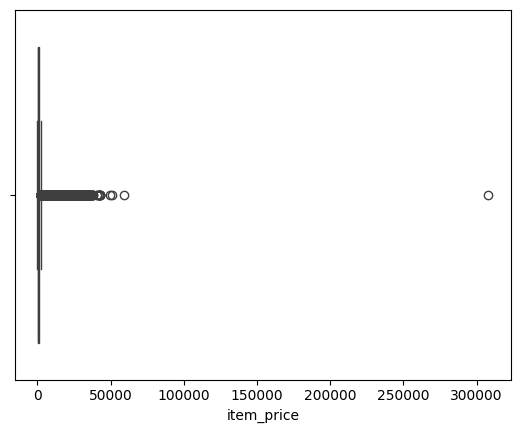

In [13]:
sns.boxplot(x=train['item_price'])

Podemos observar una importante desviación con respecto a la media en cuanto el precio de algunos productos.

In [14]:
# tamaño del conjunto de entrenamiento
train.shape

(2935843, 6)

In [15]:
# tamaño del conjunto de ventas con precios mayores a 40k
train[train['item_price']>40000].shape

(14, 6)

In [16]:
# tamaño del conjunto de ventas con precios menores o iguales a 0
train[train['item_price']<=0].shape

(1, 6)

Vemos que el de las 2,935,843 transacciones, solo el precio de 14 artículos son mayores a $40,000. Así que eliminaremos las ventas con costos superiores a $40 mil y menores o iguales a $0, y volveremos a gráficar la distribución.

In [17]:
train = train[train['item_price']<40000]
train = train[train['item_price']>0]

<Axes: xlabel='item_price'>

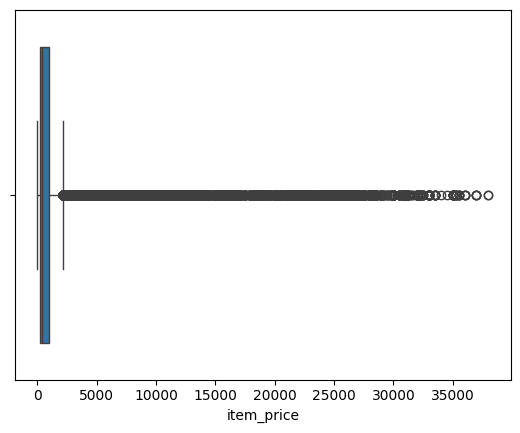

In [18]:
sns.boxplot(x=train['item_price'])

Aún vemos un notable sesgo a la derecha en los datos. Intentaremos normalizarlos, delimitando el conjunto a las ventas con un precio de artículo inferior a 5,000.

In [19]:
# tamaño del conjunto de ventas con precios mayores a 5k
train[train['item_price']>5000].shape

(33796, 6)

In [20]:
train = train[train['item_price']<5000]

<Axes: xlabel='item_price'>

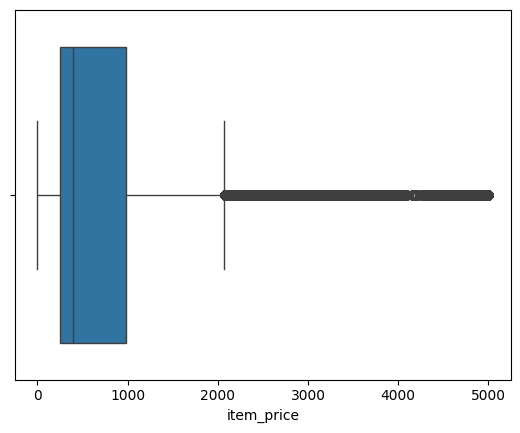

In [21]:
sns.boxplot(x=train['item_price'])

#### Distribución del número de artículos
Ahora veamos la distribución en cuanto al número de artículos en el conjunto de entrenamiento.

<Axes: xlabel='item_cnt_day'>

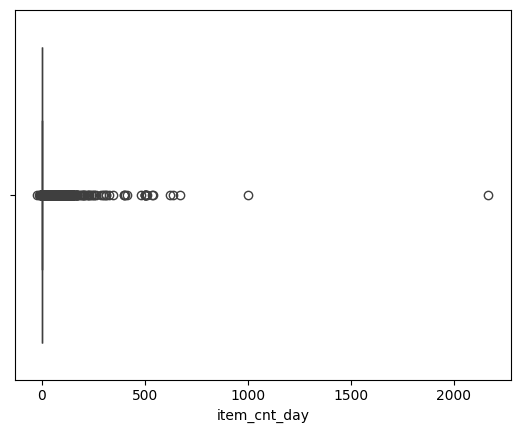

In [22]:
sns.boxplot(x=train['item_cnt_day'])

In [23]:
# ventas ordenadas por número de artículos
train.groupby('item_cnt_day')['item_id'].count().sort_values().tail(50)

item_cnt_day
 49.0         25
 45.0         31
 43.0         32
 50.0         33
 46.0         35
 42.0         35
 44.0         40
 39.0         51
 38.0         52
 41.0         56
 40.0         58
 37.0         59
 36.0         61
 35.0         68
-2.0          75
 34.0         77
 33.0         79
 29.0        100
 32.0        103
 31.0        123
 27.0        128
 28.0        129
 30.0        144
 26.0        173
 25.0        178
 23.0        195
 24.0        199
 22.0        238
 21.0        284
 19.0        342
 20.0        358
 18.0        387
 17.0        432
 16.0        536
 15.0        631
 14.0        708
 13.0        901
 12.0       1064
 11.0       1239
 10.0       1782
 9.0        2145
 8.0        2873
 7.0        3987
 6.0        6246
-1.0        7024
 5.0       10321
 4.0       19401
 3.0       46718
 2.0      191614
 1.0     2599863
Name: item_id, dtype: int64

Notamos que el mayor número de transacciones tienen ventas con menos de 12 artículos. Por lo tanto, conservaremos solo las transacciones que estén por debajo de este umbral. Además existen algunas transacciones con cantidades negativas, por lo que también nos desharemos de ellas.

In [24]:
# tamaño del conjunto de transacciones con más de 12 artículos
train[train['item_cnt_day']>12].shape

(7634, 6)

In [25]:
# tamaño del conjunto de transacciones con menos de 1 artículo
train[train['item_cnt_day']<1].shape

(7124, 6)

In [26]:
train = train[train['item_cnt_day']<12]
train = train[train['item_cnt_day']>0]

<Axes: xlabel='item_cnt_day'>

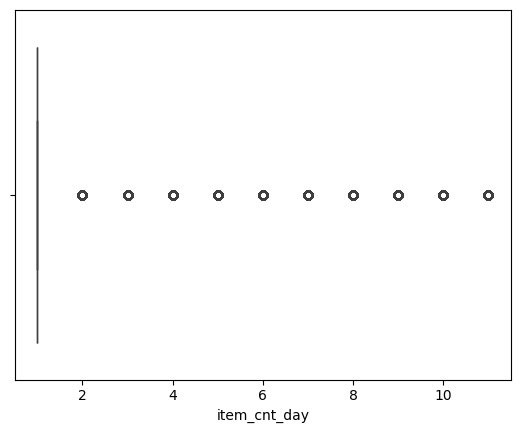

In [27]:
sns.boxplot(x=train['item_cnt_day'])

### Venta mensual de artículos

Analicemos el numéro de artículos vendidos por mes.

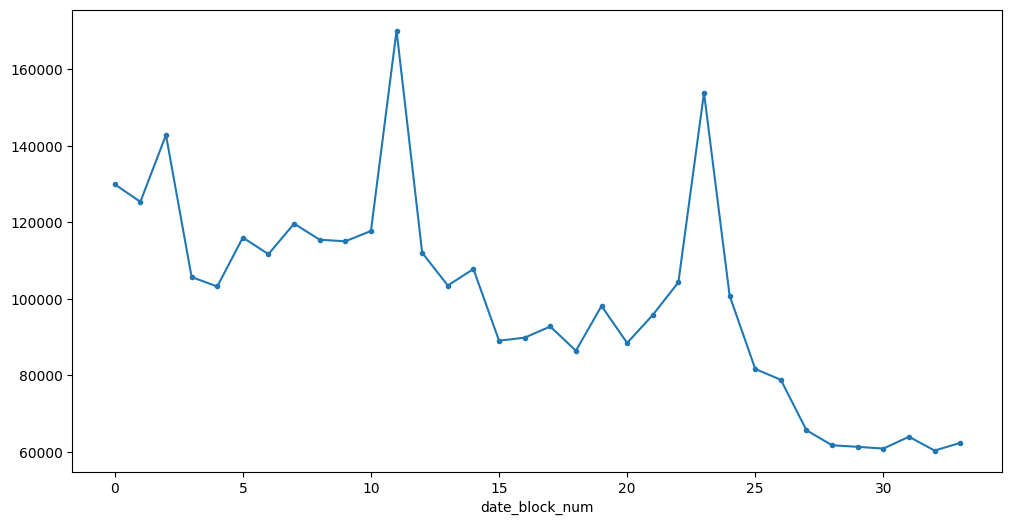

In [28]:
month_items = train.groupby('date_block_num')['item_cnt_day'].sum()

plt.figure(figsize=(12,6))
plt.grid(alpha=0.3)
month_items.plot(marker='.')
plt.show()

Veamos una versión más detallada de este gráfico agrupando los datos por día.

In [29]:
# Obtendremos el total de articulos vendidos por día
daily_items = train.groupby('date')['item_cnt_day'].sum().reset_index() # creamos un df agrupando por día  sumando el total de articulos
daily_items.set_index('date', inplace=True) # convertimos la columna con la fecha en el índice
print(daily_items.index.is_monotonic_increasing) # compobamos que las fechas estén en orden cronológico

True


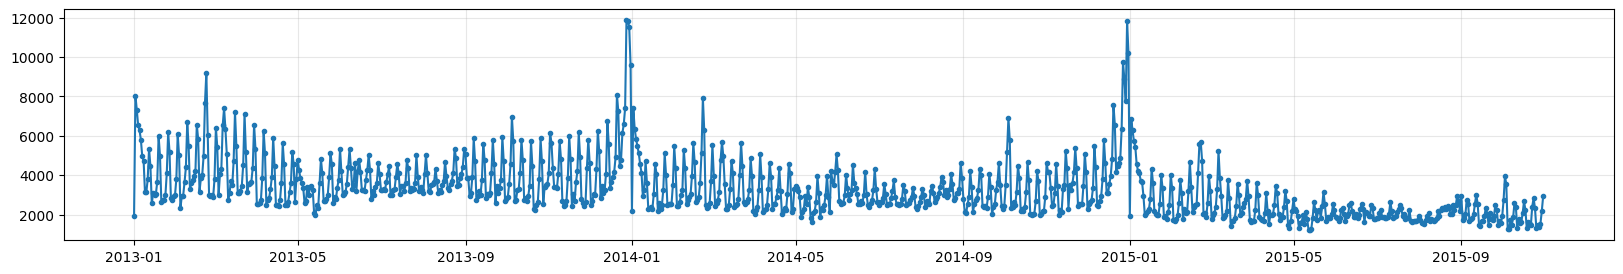

In [30]:
plt.figure(figsize=(20,3))
plt.grid(alpha=0.3)
plt.plot(daily_items, marker='.')
plt.show()

Suavizaremos los datos buscando valores menos susceptibles a fluctuaciones, es decir, utilizaremos la media aritmética. Esto con el objetivo de clarificar la tendencia y estacionalidad de los datos.

<Axes: xlabel='date'>

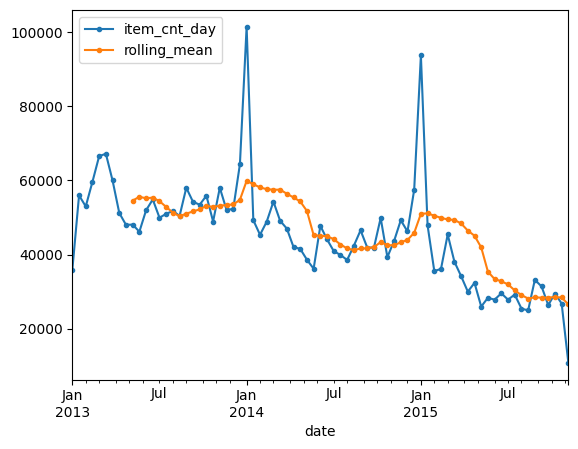

In [31]:
two_weeks_items = daily_items.resample('2W').sum() # hacemos un remuestreo de los datos a 2 semanas
two_weeks_items['rolling_mean'] = two_weeks_items.rolling(10).mean() # obtenemos la media móvil
two_weeks_items.plot(marker='.')


<Axes: xlabel='date'>

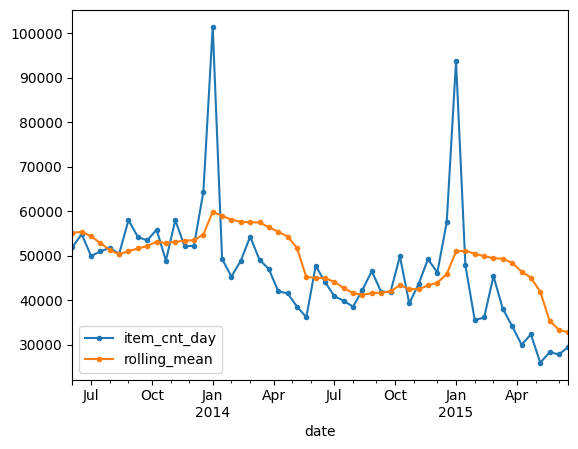

In [32]:
# obtenemos una sección más especifica del gráfico anterior
two_weeks_items['2013-06':'2015-06'].plot(marker='.')

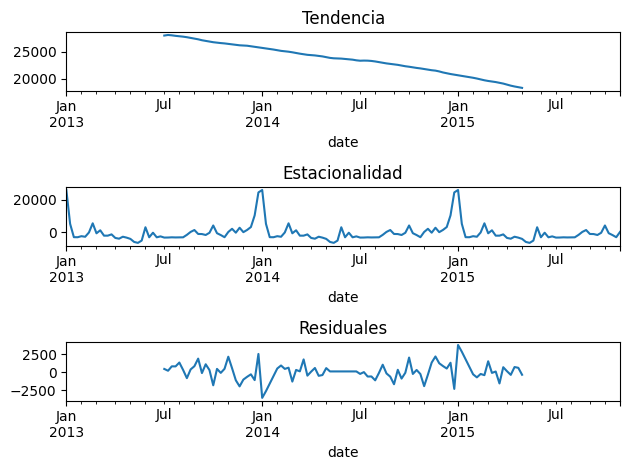

In [33]:
# gráficamos la tendencia y estacionalidad de los datos
decomposed = seasonal_decompose(daily_items.resample('1W').sum())

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuales')

plt.tight_layout() 

Podemos ver un incremento estacional en la compra de productos, durante el invierno, en dos años consecutivos. Además la tendencia general, es un decremento en las compras.

### Artículos por categoría

In [34]:
# concatenación de dataframes para la obtención de la categoría
items_category = train.merge(items, on='item_id', how='left')
items_category = items_category.merge(categories, on='item_category_id', how='left')
items_category.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
3,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
4,2013-01-10,0,25,2564,349.00,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео


In [35]:
# obtenemos el total de artículos vendidos por categoría
items_category = items_category.groupby('item_category_id')['item_cnt_day'].sum()
items_category.sort_values(ascending=False).head(10) # primeros elementos

item_category_id
40    632822.0
30    428740.0
55    348999.0
19    243429.0
37    203810.0
23    166656.0
28    157259.0
20    105982.0
71     99136.0
65     71420.0
Name: item_cnt_day, dtype: float64

In [36]:
items_category.sort_values(ascending=False).tail(10) # ultimos elementos 

item_category_id
27    8.0
48    6.0
11    4.0
53    3.0
52    3.0
50    3.0
0     3.0
1     2.0
10    1.0
51    1.0
Name: item_cnt_day, dtype: float64

<Axes: xlabel='item_category_id'>

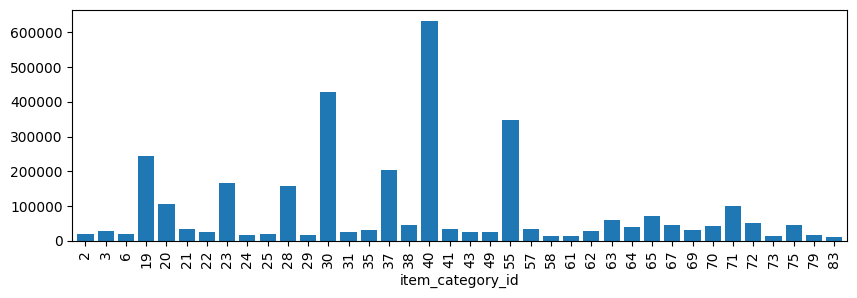

In [37]:
# gráficamos el resultado
plt.figure(figsize=(10,3))
plt.grid(alpha=0.3)
items_category[items_category>10000].plot(kind='bar', width=0.8) # gráficamos solo las categorías con más de mil productos vendidos

Observamos que la diferencia con respecto al número de productos vendidos entre diferentes categorías es muy grande, siendo la categoría con id 40 la que más productos vendió, con más de 60 mil artículos vendidos, seguida por el id 30 con más de 40 mil artículos y el id 55 con más de 30 mil artículos, en comparación con algunas categorías como el id 51 que cuenta con apenas 1 artículo vendido. 

### Artículos por tienda

In [38]:
# obtenemos el número de articulos vendidos por tienda
items_shops = train.groupby('shop_id')['item_cnt_day'].sum()

In [39]:
items_shops.sort_values(ascending=False).head(10)

shop_id
31    279435.0
25    217592.0
28    170166.0
54    170031.0
57    136000.0
42    127742.0
27    125631.0
6      94947.0
58     80142.0
56     76582.0
Name: item_cnt_day, dtype: float64

<Axes: xlabel='shop_id'>

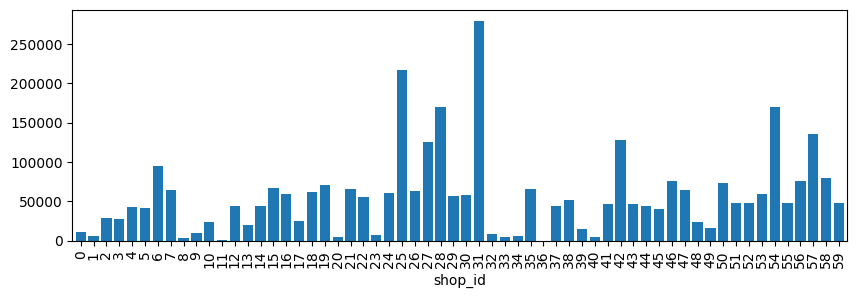

In [40]:
# gráficamos el resultado
plt.figure(figsize=(10,3))
plt.grid(alpha=0.3)
items_shops.plot(kind='bar', width=0.8)

Del mismo modo, podemos ver una diferencia importante entre el número de artículos vendidos en diferentes tiendas. Encabezando las ventas, la tienda con id 31 con poco más de 250 mil artículos, siguida por el id 25 con cerca de 217 mil artículos.

## Preparación de los datos

### Nombres de tiendas duplicados
Las siguientes tiendas tienen nombres muy similares con apenas algunas variaciones, esto indica que posiblemente se trate de la misma tienda. Por esta razón, asignaremos las referencias de el conjunto de entrenamiento y prueba a una única tienda.

In [41]:
# tiendas con nombre similares
print(shops["shop_name"][0])
print(shops["shop_name"][57])
print()
print(shops["shop_name"][1])
print(shops["shop_name"][58])
print()
print(shops["shop_name"][10])
print(shops["shop_name"][11])
print()
print(shops["shop_name"][39])
print(shops["shop_name"][40])

!Якутск Орджоникидзе, 56 фран
Якутск Орджоникидзе, 56

!Якутск ТЦ "Центральный" фран
Якутск ТЦ "Центральный"

Жуковский ул. Чкалова 39м?
Жуковский ул. Чкалова 39м²

РостовНаДону ТРК "Мегацентр Горизонт"
РостовНаДону ТРК "Мегацентр Горизонт" Островной


In [42]:
# asignamos todas las referencias a un único id de tienda

train.loc[train["shop_id"] == 0, "shop_id"] = 57
train.loc[train["shop_id"] == 1, "shop_id"] = 58
train.loc[train["shop_id"] == 10, "shop_id"] = 11
train.loc[train["shop_id"] == 39, "shop_id"] = 40

test_features.loc[test_features["shop_id"] == 0, "shop_id"] = 57
test_features.loc[test_features["shop_id"] == 1, "shop_id"] = 58
test_features.loc[test_features["shop_id"] == 10, "shop_id"] = 11
test_features.loc[test_features["shop_id"] == 39, "shop_id"] = 40

### Extracción del nombre de la ciudad
Sabemos que el nombre de cada tienda empieza con el nombre de la ciudad. Por lo tanto, extraeremos este nombre y luego lo codificaremos para el entrenamiento del modelo.

In [43]:
shops["city"] = shops["shop_name"].apply(lambda x: x.split()[0]) # obtenemos la primer palabra del nombre de la tienda
shops["city"].unique()


array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [44]:

shops.loc[shops["city"] == "!Якутск", "city"] = "Якутск" # corregimos uno de los nombres


In [45]:
# códificamos los nombres de las ciudades 

label_encoder = LabelEncoder()
shops["city"] = label_encoder.fit_transform(shops["city"])
shops = shops.drop("shop_name", axis = 1) # eliminamos el nombre de las tiendas
shops.head()

,shop_id,city
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [46]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


### Eliminación de los nombres de los artículos
Dado que los nombres de las tiendas, artículos y categorías no se pueden utilizar para las predicciones, eliminaremos estos datos posterior a la concatenación de los datos. En su lugar, usaremos los IDs correspondientes para entrenar nuestros modelos.

In [47]:
items.drop(["item_name"], axis = 1, inplace=True)

### Artículos sin ventas
Veamos si existen productos en la lista de "items" sin ventas y agreguemos una columan que lo indique

In [48]:
items['first_sold_month'] = train.groupby("item_id").agg({"date_block_num": "min"})["date_block_num"] # obtenemos el primer mes en el que cada producto fue vendido del conjunto de entrenamiento

In [49]:
items[items['first_sold_month'].isna()]

,item_id,item_category_id,first_sold_month
39,39,41,NaN
83,83,40,NaN
102,102,76,NaN
103,103,76,NaN
140,140,45,NaN
...,...,...,...
21975,21975,61,NaN
21993,21993,62,NaN
22022,22022,40,NaN
22035,22035,40,NaN


Observamos que existen 365 artículos que no tienen ventas registradas en el conjunto de entrenamiento.  
Debido a que estos productos no fueron vendidos en el rango de fechas de Enero 2013 (date_block_num = 0) a Octubre 2015 (date_block_num = 33), consideraremos que podrían realizar su primera venta en Noviembre 2015 y les asignaremos el valor 34 para que no sean considerados dentro del conjunto de datos de prueba.

In [50]:
items['first_sold_month'] = items['first_sold_month'].fillna(34)

Según la traducción, la primera palabra en el nombre de la categoría es la que realmente se refiere al nombre, mientras que la segunda palabra es una subcategoría. Por lo tanto, crearemos una nueva característica con la categoría principal y la códificaremos posteriormente.

In [51]:
categories['item_category_name'].sample(20)

8                        Билеты (Цифра)
20                           Игры - PS4
30        Игры PC - Стандартные издания
54                        Книги - Цифра
77                Программы - Обучающие
4                      Аксессуары - PSP
51    Книги - Познавательная литература
50                     Книги - Открытки
41                 Кино - Коллекционное
27                     Игры MAC - Цифра
67                   Подарки - Развитие
78        Программы - Обучающие (Цифра)
64            Подарки - Настольные игры
44           Книги - Аудиокниги (Цифра)
45                Книги - Аудиокниги 1С
28     Игры PC - Дополнительные издания
6                 Аксессуары - XBOX 360
21                           Игры - PSP
63             Подарки - Мягкие игрушки
3                      Аксессуары - PS4
Name: item_category_name, dtype: object

In [52]:
categories["main_category"]=categories["item_category_name"].apply(lambda x: x.split()[0])  # obtenemos la primera palabra de cada categoría
categories["main_category"].value_counts() # obtenemos un conteo de los valores únicos

main_category
Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: count, dtype: int64

In [53]:
label_encoder = LabelEncoder()

categories["main_category"] = label_encoder.fit_transform(categories["main_category"]) # códificamos las categorías principales
categories.drop("item_category_name", axis = 1, inplace=True) # eliminamos el nombre de las categorías

In [54]:
# obtención del mes de la primera venta
#train = train.merge(items, on='item_id', how='left')
# obtención de la categoría principal
#train = train.merge(categories, on='item_category_id', how='left')
#obtención de la ciudad
#train = train.merge(shops, on='shop_id', how='left')

In [55]:
train.info(show_counts=True)
train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2886189 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   date            2886189 non-null  datetime64[ns]
 1   date_block_num  2886189 non-null  int64         
 2   shop_id         2886189 non-null  int64         
 3   item_id         2886189 non-null  int64         
 4   item_price      2886189 non-null  float64       
 5   item_cnt_day    2886189 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 154.1 MB


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0


### Ganancias
Obtengamos una nueva columna la cuál indique las ganancias. Es decir, el precio por el número de artículos vendidos de cada transacción.

In [56]:
#train['revenue'] = train['item_price'] * train['item_cnt_day']

### Agrupación mensual

Agruparemos los datos por mes, tienda y artículo.

In [57]:
monthly_sales = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
    'item_cnt_day':'sum',
    #'revenue':'sum'
}).reset_index()

In [58]:
# cambiamos el nombre de la columna de cantidades
monthly_sales.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)

In [59]:
monthly_sales.head(10)

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0
5,0,2,481,1.0
6,0,2,482,1.0
7,0,2,484,2.0
8,0,2,491,1.0
9,0,2,534,2.0


### Integración del conjunto de entrenamiento

In [60]:
# obtenemos el mes de la primera venta
monthly_sales = monthly_sales.merge(items, on='item_id', how='left')
# obtenemos la categoría principal
monthly_sales = monthly_sales.merge(categories, on='item_category_id', how='left')
# obtenemos la ciudad
monthly_sales = monthly_sales.merge(shops, on='shop_id', how='left')

In [61]:
monthly_sales.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,first_sold_month,main_category,city
0,0,2,27,1.0,19,0.0,5,0
1,0,2,33,1.0,37,0.0,7,0
2,0,2,317,1.0,45,0.0,8,0
3,0,2,438,1.0,45,0.0,8,0
4,0,2,471,2.0,49,0.0,8,0
5,0,2,481,1.0,49,0.0,8,0
6,0,2,482,1.0,73,0.0,11,0
7,0,2,484,2.0,73,0.0,11,0
8,0,2,491,1.0,73,0.0,11,0
9,0,2,534,2.0,77,0.0,11,0


In [62]:
# observamos que los datos estén dentro del rango de meses establecido
print(monthly_sales[monthly_sales["first_sold_month"]<0])
print(monthly_sales[monthly_sales["first_sold_month"]>33])

Empty DataFrame
Columns: [date_block_num, shop_id, item_id, item_cnt_month, item_category_id, first_sold_month, main_category, city]
Index: []
Empty DataFrame
Columns: [date_block_num, shop_id, item_id, item_cnt_month, item_category_id, first_sold_month, main_category, city]
Index: []


In [63]:
test_features

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [64]:
test_tarjet

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5


Sabemos que el campo 'date_block_num' para los datos de prueba es 34, es decir, noviembre del 2015. Además podemos obtener el id de la categoría, la categoría principal, el primer mes de venta, la ciudad y el precio de los artículos del conjunto de entrenamiento. Además podemos eliminar las columnas ID de los conjuntos correspondientes a las características y objetivo de prueba, ya que son identicos al índice de sus respectivos dataframes.

In [65]:
# eliminamos la columna ID de los conjuntos de de prueba
test_features.drop(['ID'],axis=1,inplace=True)
test_tarjet.drop(['ID'],axis=1,inplace=True)

In [66]:
# Obtenemos las características faltantes para el conjunto de prueba

# obtenemos el mes de la primera venta
test_features = test_features.merge(items, on='item_id', how='left')
# obtenemos la categoría principal
test_features = test_features.merge(categories, on='item_category_id', how='left')
# obtenemos la ciudad
test_features = test_features.merge(shops, on='shop_id', how='left')

In [67]:
# buscamos valores ausentes
test_features.isna().sum()

shop_id             0
item_id             0
item_category_id    0
first_sold_month    0
main_category       0
city                0
dtype: int64

In [68]:
# insertamos el id del mes en la primer columna para el conjunto de prueba
test_features.insert(0, 'date_block_num', 34)

In [69]:
# concatenamos los datos de prueba para hacer la agrupación
test = pd.concat([test_features, test_tarjet], axis='columns')

## Segmentación de los datos
Una vez que contamos únicamente con características numéricas, separaremos los datos de entrenamiento y prueba en 4 conjuntos, 2 con las características y 2 con el objetivo.  
En nuestro caso, debemos predecir la cantidad de artículos vendidos considerando dos factores: el producto y la tienda. La primera agrupación ya está lista, puesto que disponemos de un DataFrame agrupado por mes, tienda y producto. Ahora, solo es necesario generar un nuevo conjunto de entrenamiento y otro de prueba, pero esta vez con la agrupación enfocada únicamente en la tienda.

In [70]:
# conjunto de entrenamiento por producto
train_features_item = monthly_sales.drop(['item_cnt_month'],axis='columns')
train_tarjet_item = monthly_sales['item_cnt_month']

In [71]:
# conjunto de prueba por producto
test_features_item = test_features
test_tarjet_item = test_tarjet

In [72]:
# conjunto de entrenamiento por tienda
train_store = monthly_sales.groupby(['date_block_num','shop_id'])['item_cnt_month'].sum().reset_index()
train_store = train_store.merge(shops, on='shop_id', how='left') # obtenemos la ciudad

train_features_store = train_store.drop(['item_cnt_month'],axis='columns') # características
train_tarjet_store = train_store['item_cnt_month'] # objetivo

In [73]:
# conjunto de prueba por tienda
test_store = test.groupby(['date_block_num','shop_id'])['item_cnt_month'].sum().reset_index()
test_store = test_store.merge(shops, on='shop_id', how='left') # obtenemos la ciudad

test_features_store = test_store.drop(['item_cnt_month'],axis='columns') # características
test_tarjet_store = test_store['item_cnt_month'] # objetivo

## Normalización de características
Ahora normalizaremos las datos de entrenamiento, ya que las escalas de las características son muy diferentes entre sí.

In [ ]:
scaler_1 = StandardScaler()

train_features_item_array = scaler_1.fit_transform(train_features_item).astype(float)
test_features_item_array = scaler_1.transform(test_features_item)

scaler_2 = StandardScaler()

train_features_store_array = scaler_2.fit_transform(train_features_store)
test_features_store_array = scaler_2.transform(test_features_store)

Debido a que StandarScaler transforma los dataframes en arrays de numpy, aplicaremos algunas transformaciones para regresar al formato original. 

In [77]:
train_features_item = pd.DataFrame(train_features_item_array, columns=train_features_item.columns)
test_features_item = pd.DataFrame(test_features_item_array, columns=test_features_item.columns)
train_features_store = pd.DataFrame(train_features_store_array, columns=train_features_store.columns)
test_features_store = pd.DataFrame(test_features_store_array, columns=test_features_store.columns)

## Entrenamiento  del modelo